In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
from torch.nn import Parameter
from torch.nn import Module
from torch.optim import lr_scheduler

import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from skimage import io

import math
import numpy as np
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import ImageGrid

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
"""
    This is the parameters dictionary. Choose the configuration of the run for the notebook:
        - model : select one between the options
                  ResNet | AlexNet | BAlexNet | DNet | BDNet | ConvNext | BConvNext
        - val : set to True if you want to start the validation process; splits the training data
                in train and val set and evaluate the performance of the model. For the submission of
                the notebook, set val to False.
        - batch_size : the size of the batch
        - n_epochs : number of epochs for the training
        - num_channels : number of inputs channels (default = 3)
        - classes : number of classes (default = 2)
"""

par = {
    'model' : "BConvNext",
    'expID' : 0,
    'num_ens' : 5,
    'batch_size' : 32,
    'n_epochs' : 20,
    'num_channels' : 3,
    'classes' : 2
}

In [3]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.50359046, 0.45194104, 0.46817818])
    std = np.array([0.15118405, 0.13978378, 0.15320341])
    inp = std * inp + mean
    axis.imshow(inp)
    
def plot_prior_posterior(net, epoch, iteration):
        
        loc = net.linear.W_mu[0][0].item()
        scale = net.linear.W_sigma[0][0].item()
        x = np.arange(0, 0.1, 0.0001)
        y = stats.norm.pdf(x, loc, scale)
        fig, _ = plt.subplots(figsize=(10, 8))
        
        distribution = np.random.normal(loc, scale, 1000)
        sns.histplot(distribution, bins=80, alpha=0.5, label='Weight Distribution', kde=True)
        plt.ylabel('Weights')
        plt.title('Prior distribution')
        plt.show()

def plot_loss(losses, epoch):
        fig, _ = plt.subplots(figsize=(10, 8))

        plt.plot(losses, color='blue', linewidth=2)
        plt.xlabel('Iteration')
        plt.ylabel('ELBO loss')
        plt.title('Losses during training')
        plt.show()

def plot_confusion_matrix(y_true, y_pred):
        # constant for classes
        classes = ('no', 'yes')

        # Build confusion matrix
        cf_matrix = confusion_matrix(y_true, y_pred)

        df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                            columns = [i for i in classes])
        
        fig, _ = plt.subplots(figsize = (10, 8))

        sns.heatmap(df_cm, annot=True)
        
        plt.show()
        
def logmeanexp(x, dim=None, keepdim=False):
    """Stable computation of log(mean(exp(x))"""

    if dim is None:
        x, dim = x.view(-1), 0
    x_max, _ = torch.max(x, dim, keepdim=True)
    x = x_max + torch.log(torch.mean(torch.exp(x - x_max), dim, keepdim=True))
    return x if keepdim else x.squeeze(dim)

# Dataset

In [4]:
class CactusDataset(Dataset):

    def __init__(self, dataframe, img_dir, labels=None, transform=None):
        self.dataframe = dataframe
        self.labels = labels
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):

        img_id=self.dataframe.iloc[idx].values[0]
        img_path = os.path.join(self.img_dir, img_id)

        image = Image.open(img_path).convert("RGB")
         

        if self.transform is not None:
            image = self.transform(image)

        if self.labels is not None:
            label = torch.tensor(float(self.labels.iloc[idx])) 
            label = label.type(torch.LongTensor)
            return (image, label)
        
        return image

In [5]:
"""
import os
import numpy as np
from PIL import Image

folder_path = "/kaggle/input/eurecom-aml-2023-optional-challenge-1/train/train/"  # cartella contenente le immagini
red_pixels = []  # lista di pixel rossi
green_pixels = []  # lista di pixel rossi
blue_pixels = []  # lista di pixel rossi

for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # considera solo file di immagine
        img_path = os.path.join(folder_path, filename)
        img = Image.open(img_path)  # carica l'immagine
        img = img.resize((32, 32))  # ridimensiona l'immagine a 32x32
        img = np.array(img).astype(np.float32) / 255.0  # converte l'immagine in array NumPy e normalizza i valori dei pixel tra 0 e 1
        red_channel = img[:, :, 0]  # estrae il canale rosso
        red_pixels += list(red_channel.flatten())  # aggiunge i pixel rossi alla lista
        green_channel = img[:, :, 1]  # estrae il canale rosso
        green_pixels += list(green_channel.flatten())  # aggiunge i pixel rossi alla lista
        blue_channel = img[:, :, 2]  # estrae il canale rosso
        blue_pixels += list(blue_channel.flatten())  # aggiunge i pixel rossi alla lista

red_pixels_mean = np.mean(red_pixels)  # media dei pixel rossi
red_pixels_std = np.std(red_pixels)  # deviazione standard dei pixel rossi
green_pixels_mean = np.mean(green_pixels)  # media dei pixel rossi
green_pixels_std = np.std(green_pixels)  # deviazione standard dei pixel rossi
blue_pixels_mean = np.mean(blue_pixels)  # media dei pixel rossi
blue_pixels_std = np.std(blue_pixels)  # deviazione standard dei pixel rossi

print("Media dei pixel rossi: ", red_pixels_mean, green_pixels_mean, blue_pixels_mean)
print("Deviazione standard dei pixel rossi: ", red_pixels_std, green_pixels_std, blue_pixels_std)

    """

'\nimport os\nimport numpy as np\nfrom PIL import Image\n\nfolder_path = "/kaggle/input/eurecom-aml-2023-optional-challenge-1/train/train/"  # cartella contenente le immagini\nred_pixels = []  # lista di pixel rossi\ngreen_pixels = []  # lista di pixel rossi\nblue_pixels = []  # lista di pixel rossi\n\nfor filename in os.listdir(folder_path):\n    if filename.endswith(".jpg") or filename.endswith(".png"):  # considera solo file di immagine\n        img_path = os.path.join(folder_path, filename)\n        img = Image.open(img_path)  # carica l\'immagine\n        img = img.resize((32, 32))  # ridimensiona l\'immagine a 32x32\n        img = np.array(img).astype(np.float32) / 255.0  # converte l\'immagine in array NumPy e normalizza i valori dei pixel tra 0 e 1\n        red_channel = img[:, :, 0]  # estrae il canale rosso\n        red_pixels += list(red_channel.flatten())  # aggiunge i pixel rossi alla lista\n        green_channel = img[:, :, 1]  # estrae il canale rosso\n        green_pixe

torch.Size([32, 3, 32, 32]) torch.Size([32])


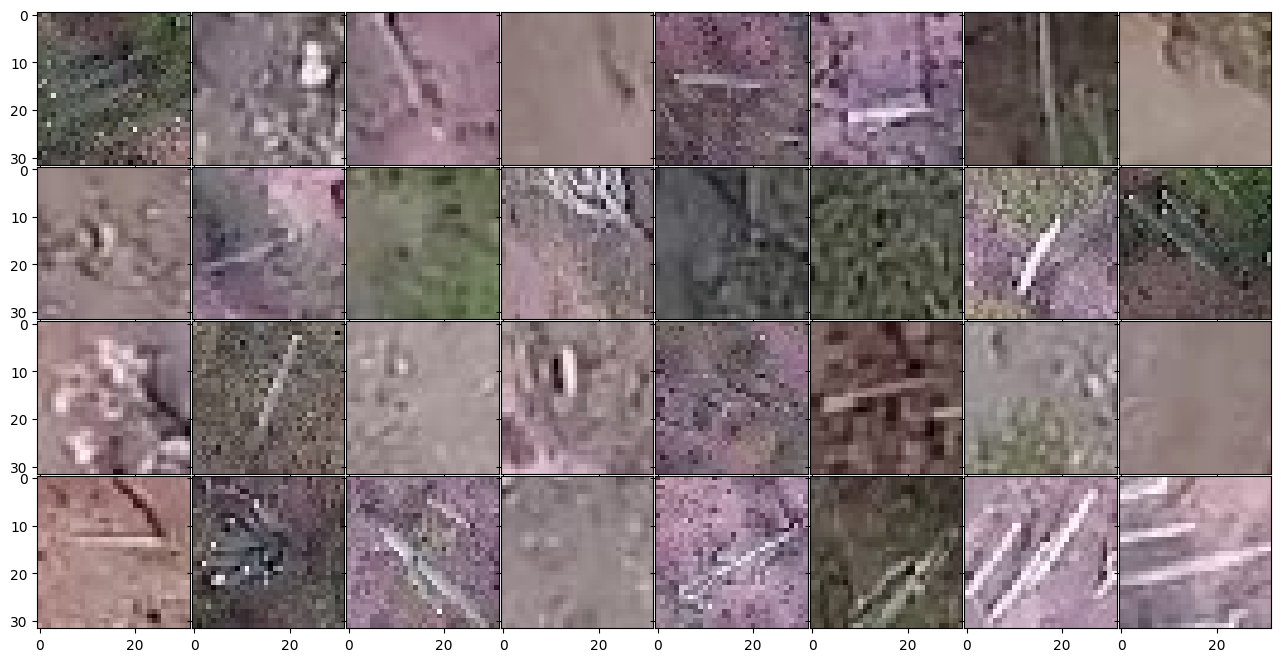

In [6]:
df = pd.read_csv("/kaggle/input/eurecom-aml-2023-optional-challenge-1/train.csv")

batch_size = par['batch_size']

labels = df['has_cactus']
df = df.drop(columns=['has_cactus'])

normalize = transforms.Normalize(
   mean=[0.50359046, 0.45194104, 0.46817818],
   std=[0.15118405, 0.13978378, 0.15320341]
)

transform = transforms.Compose([transforms.ToTensor(), normalize])

dataset = CactusDataset(dataframe=df, labels=labels,
                        img_dir="/kaggle/input/eurecom-aml-2023-optional-challenge-1/train/train",
                        transform=transform)

train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size

train_ds, valid_ds = torch.utils.data.random_split(dataset, [train_size, valid_size])



train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True, num_workers=2)

img, label = next(iter(train_dl))
print(img.size(), label.size())
fig = plt.figure(1, figsize=(32, 8))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 8))    
for i in range(img.size()[0]):
    ax = grid[i]
    imshow(ax, img[i])

# Bayesian CNN

## Loss

In [7]:
class ELBO(nn.Module):
    def __init__(self, train_size):
        super(ELBO, self).__init__()
        self.train_size = train_size

    def forward(self, input, target, kl=0, beta=0):
        assert not target.requires_grad
        return F.nll_loss(input, target, reduction='mean')  + beta * kl


def acc(outputs, targets):
    return np.mean(outputs.cpu().numpy().argmax(axis=1) == targets.data.cpu().numpy())


def calculate_kl(mu_q, sig_q, mu_p, sig_p):
    """
    q = tfp.distributions.MultivariateNormalDiag(loc=mu_q.numpy(), scale_diag=sig_q.numpy())
    p = tfp.distributions.MultivariateNormalDiag(loc=mu_p.numpy(), scale_diag=sig_p.numpy())
    kl = tfp.distributions.kl_divergence(q, p)
    """
    kl = 0.5 * (2 * (torch.log(sig_p) - np.log(sig_q)) - 1 + (sig_q / sig_p).pow(2) + ((mu_p - mu_q) / sig_p).pow(2)).sum()

    return kl


def get_beta(batch_idx, m, beta_type, epoch, num_epochs):
    if type(beta_type) is float:
        return beta_type

    if beta_type == "Blundell":
        beta = 2 ** (m - (batch_idx + 1)) / (2 ** m - 1)
    elif beta_type == "Soenderby":
        if epoch is None or num_epochs is None:
            raise ValueError('Soenderby method requires both epoch and num_epochs to be passed.')
        beta = min(epoch / (num_epochs // 4), 1)
    elif beta_type == "Standard":
        beta = 1 / m
    else:
        beta = 0
    return beta

## Module Wrapper

In [8]:
class ModuleWrapper(nn.Module):
    """Wrapper for nn.Module with support for arbitrary flags and a universal forward pass"""

    def __init__(self):
        super(ModuleWrapper, self).__init__()

    def set_flag(self, flag_name, value):
        setattr(self, flag_name, value)
        for m in self.children():
            if hasattr(m, 'set_flag'):
                m.set_flag(flag_name, value)

    def forward(self, x):
        for module in self.children():
            x = module(x)

        kl = 0.0
        for module in self.modules():
            if hasattr(module, 'kl_loss'):
                kl = kl + module.kl_loss()

        return x, kl


class FlattenLayer(ModuleWrapper):

    def __init__(self, num_features):
        super(FlattenLayer, self).__init__()
        self.num_features = num_features

    def forward(self, x):
        return x.view(-1, self.num_features)

## BConv2d

In [9]:
class BConv2d(ModuleWrapper):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1, bias=True, priors=None, groups=1):

        super(BConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = 1
        self.use_bias = bias
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        if priors is None:
            priors = {
                'prior_mu': 0,
                'prior_sigma': 0.1,
                'posterior_mu_initial': (0, 0.1),
                'posterior_rho_initial': (-5, 0.1),
            }
        self.prior_mu = priors['prior_mu']
        self.prior_sigma = priors['prior_sigma']
        self.posterior_mu_initial = priors['posterior_mu_initial']
        self.posterior_rho_initial = priors['posterior_rho_initial']

        self.W_mu = Parameter(torch.empty((out_channels, in_channels, *self.kernel_size), device=self.device))
        self.W_rho = Parameter(torch.empty((out_channels, in_channels, *self.kernel_size), device=self.device))

        if self.use_bias:
            self.bias_mu = Parameter(torch.empty((out_channels), device=self.device))
            self.bias_rho = Parameter(torch.empty((out_channels), device=self.device))
        else:
            self.register_parameter('bias_mu', None)
            self.register_parameter('bias_rho', None)

        self.reset_parameters()

    def reset_parameters(self):
        self.W_mu.data.normal_(*self.posterior_mu_initial)
        self.W_rho.data.normal_(*self.posterior_rho_initial)

        if self.use_bias:
            self.bias_mu.data.normal_(*self.posterior_mu_initial)
            self.bias_rho.data.normal_(*self.posterior_rho_initial)

    def forward(self, input, sample=True):
        if self.training or sample:
            """
                sigma = log(1 + exp(rho)) -> sampling the weight from the gaussian distribution of parameters mu and sigma.
                eps is sampled from a standard normal distribution.
            """
            W_eps = torch.empty(self.W_mu.size()).normal_(0, 1).to(self.device)
            # usare direttamente rho
            self.W_sigma = torch.log1p(torch.exp(self.W_rho))
            # self.W_sigma = torch.exp(self.W_rho)
            weight = self.W_mu + W_eps * self.W_sigma

            if self.use_bias:
                bias_eps = torch.empty(self.bias_mu.size()).normal_(0, 1).to(self.device)
                self.bias_sigma = torch.log1p(torch.exp(self.bias_rho))
                bias = self.bias_mu + bias_eps * self.bias_sigma
            else:
                bias = None
        else:
            weight = self.W_mu
            bias = self.bias_mu if self.use_bias else None

        return F.conv2d(input, weight, bias, self.stride, self.padding, self.dilation, self.groups)

    def kl_loss(self):
        kl = calculate_kl(self.prior_mu, self.prior_sigma, self.W_mu, self.W_sigma)
        if self.use_bias:
            kl += calculate_kl(self.prior_mu, self.prior_sigma, self.bias_mu, self.bias_sigma)
        return kl

## BLinear

In [10]:
class BLinear(ModuleWrapper):
    
    def __init__(self, in_features, out_features, bias=True, priors=None):
        super(BLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = bias
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        if priors is None:
            priors = {
                'prior_mu': 0,
                'prior_sigma': 0.1,
                'posterior_mu_initial': (0, 0.1),
                'posterior_rho_initial': (-5, 0.1),
            }
        self.prior_mu = priors['prior_mu']
        self.prior_sigma = priors['prior_sigma']
        self.posterior_mu_initial = priors['posterior_mu_initial']
        self.posterior_rho_initial = priors['posterior_rho_initial']

        self.W_mu = Parameter(torch.empty((out_features, in_features), device=self.device))
        self.W_rho = Parameter(torch.empty((out_features, in_features), device=self.device))

        if self.use_bias:
            self.bias_mu = Parameter(torch.empty((out_features), device=self.device))
            self.bias_rho = Parameter(torch.empty((out_features), device=self.device))
        else:
            self.register_parameter('bias_mu', None)
            self.register_parameter('bias_rho', None)

        self.reset_parameters()

    def reset_parameters(self):
        self.W_mu.data.normal_(*self.posterior_mu_initial)
        self.W_rho.data.normal_(*self.posterior_rho_initial)

        if self.use_bias:
            self.bias_mu.data.normal_(*self.posterior_mu_initial)
            self.bias_rho.data.normal_(*self.posterior_rho_initial)

    def forward(self, input, sample=True):
        if self.training or sample:
            W_eps = torch.empty(self.W_mu.size()).normal_(0, 1).to(self.device)
            self.W_sigma = torch.log1p(torch.exp(self.W_rho))
            # self.W_sigma = torch.exp(self.W_rho)
            weight = self.W_mu + W_eps * self.W_sigma

            if self.use_bias:
                bias_eps = torch.empty(self.bias_mu.size()).normal_(0, 1).to(self.device)
                self.bias_sigma = torch.log1p(torch.exp(self.bias_rho))
                bias = self.bias_mu + bias_eps * self.bias_sigma
            else:
                bias = None
        else:
            weight = self.W_mu
            bias = self.bias_mu if self.use_bias else None

        return F.linear(input, weight, bias)
    
    

    def kl_loss(self):
        kl = calculate_kl(self.prior_mu, self.prior_sigma, self.W_mu, self.W_sigma)
        if self.use_bias:
            kl += calculate_kl(self.prior_mu, self.prior_sigma, self.bias_mu, self.bias_sigma)
        return kl

## ConvNeXt block

In [11]:
class ConvNeXtBlock(Module):
    def __init__(self, res):
        super(ConvNeXtBlock, self).__init__()
        self.layer1=nn.Conv2d(in_channels=3, out_channels=3,
                          kernel_size=7, padding=3,
                          groups=3)
        self.ln=LayerNorm(normalized_shape=(3,res,res))
        self.layer2=nn.Conv2d(in_channels=3, out_channels=12,
                           kernel_size=1)
        self.gelu=nn.GELU()
        self.layer3=nn.Conv2d(in_channels=12, out_channels=3,
                           kernel_size=1)
        
    def forward(self, x):
        y=self.layer1(x)
        y=self.ln(y)
        y=self.layer2(y)
        y=self.gelu(y)
        y=self.layer3(y)
        return y+x
    
class LayerNorm(nn.Module):
    r""" LayerNorm that supports two data formats: channels_last (default) or channels_first. 
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with 
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs 
    with shape (batch_size, channels, height, width).
    """
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError 
        self.normalized_shape = normalized_shape
    
    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x

## BConvNeXt Block

In [12]:
class BConvNeXtBlock(ModuleWrapper):
    def __init__(self, res):
        super(BConvNeXtBlock, self).__init__()
        self.layer1=BConv2d(in_channels=3, out_channels=3,
                          kernel_size=7, padding=3,
                          groups=3)
        self.ln=LayerNorm(normalized_shape=(3,res,res))
        self.layer2=BConv2d(in_channels=3, out_channels=12,
                           kernel_size=1)
        self.gelu=nn.GELU()
        self.layer3=BConv2d(in_channels=12, out_channels=3,
                           kernel_size=1)
    def forward(self, x):
        identity=x
        for module in self.children():
            x = module(x)
        kl = 0.0
        for module in self.modules():
            if hasattr(module, 'kl_loss'):
                kl = kl + module.kl_loss()
        return x+identity, kl

# Models

In [13]:
######################### AlexNet ##########################

class AlexNet(nn.Module):
    def __init__(self, num_channels, classes):
        
        super(AlexNet, self).__init__()
        self.num_classes = classes
        self.num_channels = num_channels
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=num_channels, out_channels=64, kernel_size=11,
                              stride=4, padding=5, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 192, 5, padding=2, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(192, 384, 3, padding=1, bias=True),
            nn.ReLU()
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 256, 3, padding=1, bias=True),
            nn.ReLU()
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.flatten = FlattenLayer(1 * 1 * 128)

        self.linear = nn.Linear(in_features=128, out_features=classes)
        
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.flatten(x)
        x = self.linear(x)
        x = self.softmax(x)
        
        return x

######################### BAlexNet #########################

class BAlexNet(ModuleWrapper):
    def __init__(self, num_channels, classes):
        
        super(BAlexNet, self).__init__()
        self.num_classes = classes
        self.num_channels = num_channels
        self.layer1 = nn.Sequential(
            BConv2d(in_channels=num_channels, out_channels=64, kernel_size=11,
                              stride=4, padding=5, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            BConv2d(64, 192, 5, padding=2, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer3 = nn.Sequential(
            BConv2d(192, 384, 3, padding=1, bias=True),
            nn.ReLU()
        )

        self.layer4 = nn.Sequential(
            BConv2d(384, 256, 3, padding=1, bias=True),
            nn.ReLU()
        )

        self.layer5 = nn.Sequential(
            BConv2d(256, 128, 3, padding=1, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.flatten = FlattenLayer(1 * 1 * 128)

        self.linear = BLinear(in_features=128, out_features=classes)
        
        self.log_softmax = nn.LogSoftmax(dim=1)
        

######################### DNet ##########################

class DNet(Module):
    def __init__(self, numChannels, classes):
        super(DNet, self).__init__()

        #[[CONV => ReLU]*N => POOL]; N=2   (es: 32x32x3)
        self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=5,
                            kernel_size=(5,5), stride=1, padding=2)     # 32x32x5
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=10,
                            kernel_size=(3,3), stride=1, padding=1)     # 32x32x10
        self.relu2 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))    # 16x16x10

        #[[CONV => ReLU]*N => POOL]; N=1
        self.conv3 = nn.Conv2d(in_channels=10, out_channels=15,            # 16x16x15
                            kernel_size=(3,3), stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))    # 8x8x15

        #[FC => ReLU]*K => FC; K=1
        self.fc1 = nn.Linear(in_features=960, out_features=400)      # in_feature = 8x8x15 = 960
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=400, out_features=classes)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x) #32*32*20
        x = self.relu1(x) 
        x = self.conv2(x) #32*32*3
        x = self.relu2(x)
        x = self.maxpool1(x) #16*16*3

        x = self.conv3(x) #
        x = self.relu3(x)
        x = self.maxpool2(x)

        x = torch.flatten(x, 1)   # x is a multi-dimensional tensor,
                            # we need to “flatten” it into a 1D list of values
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)
        output = self.softmax(x)

        return output

############################### BDNet #################################

class BDNet(ModuleWrapper):
    def __init__(self, num_channels, classes):
        super(BDNet, self).__init__()
        self.num_classes = classes
        #[[CONV => ReLU]*N => POOL]; N=2   (es: 32x32x3)
        self.conv1 = BConv2d(in_channels=num_channels, out_channels=5,
                            kernel_size=(5,5), stride=1, padding=2)     # 32x32x5
        self.relu1 = nn.ReLU()
        self.conv2 = BConv2d(in_channels=5, out_channels=10,
                            kernel_size=(3,3), stride=1, padding=1)     # 32x32x10
        self.relu2 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))    # 16x16x10

        #[[CONV => ReLU]*N => POOL]; N=1
        self.conv3 = BConv2d(in_channels=10, out_channels=15,            # 16x16x15
                            kernel_size=(3,3), stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))    # 8x8x15
        
        self.flatten = FlattenLayer(960)
        
        #[FC => ReLU]*K => FC; K=1
        self.fc1 = BLinear(in_features=960, out_features=400)      # in_feature = 8x8x15 = 960
        self.relu4 = nn.ReLU()
        self.fc2 = BLinear(in_features=400, out_features=classes)

        self.log_softmax = nn.LogSoftmax(dim=1)
    
    
################################# ConvNeXt ################################   

class ConvNeXt(Module):
    def __init__(self, num_classes, res=32):
        super(ConvNeXt, self).__init__()
        
        self.num_classes = num_classes
        self.conv_next = nn.Sequential(ConvNeXtBlock(res),ConvNeXtBlock(res),ConvNeXtBlock(res),ConvNeXtBlock(res))
        
        self.fc = nn.Linear(3*(res**2), 2)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x= self.conv_next(x)
        x = torch.flatten(x, 1)   # x is a multi-dimensional tensor,
                            # we need to “flatten” it into a 1D list of values
        x = self.fc(x)
        return self.softmax(x)
    
################################# BConvNeXt ##############################

class BConvNeXt(ModuleWrapper):
    def __init__(self, num_classes, res=32):
        super(BConvNeXt, self).__init__()
        self.num_classes = num_classes
        self.conv_next1 = BConvNeXtBlock(res)
        self.conv_next2 = BConvNeXtBlock(res)
        self.conv_next3 = BConvNeXtBlock(res)
        self.conv_next4 = BConvNeXtBlock(res)
        self.conv_next5 = BConvNeXtBlock(res)
        self.flatten = FlattenLayer(3072)
        self.fc1 = BLinear(3*(res**2), 2)
        self.log_softmax = nn.LogSoftmax(dim=1)
    def forward(self, x):
        kl = 0.0
        out = self.conv_next1(x)
        x = out[0]
        kl += out[1]
        out = self.conv_next2(x)
        x = out[0]
        kl += out[1]
        out = self.conv_next3(x)
        x = out[0]
        kl += out[1]
        out = self.conv_next4(x)
        x = out[0]
        kl += out[1]
        out = self.conv_next5(x)
        x = out[0]
        kl += out[1]
        x = self.flatten(x)
        x = self.fc1(x)
        kl += self.fc1.kl_loss()
        return self.log_softmax(x), kl
    

# Train-Test

In [14]:
def train_val(net, criterion, optimizer, lr_scheduler, n_epochs, train_loader, val_loader, device):

    scores = []
    num_ens = par['num_ens']
    train_losses = []
    val_losses = []
    best_loss = 1e10
    best_model = None
    
    for epoch in range(n_epochs):
        
        net.train()
        training_loss_iters = 0.0
        loss_list = []
        

        print('EPOCH {}/{}'.format(epoch+1, n_epochs))

        for i, (inputs, labels) in tqdm(enumerate(train_loader), desc='Iteration', leave=True):

            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)

            if par['model'].startswith("B"):  
                
                outputs_ens = torch.zeros(inputs.shape[0], net.num_classes, num_ens).to(device)
                kl = 0.0
                
                for j in range(num_ens):
                    net_out, _kl = net(inputs)
                    kl += _kl
                    outputs_ens[:, :, j] = F.log_softmax(net_out, dim=1)
        
                kl = kl / num_ens
                outputs = logmeanexp(outputs_ens, dim=2)
                
                beta = get_beta(i-1, len(train_loader), beta_type="standard", epoch=epoch, num_epochs=n_epochs)
                loss = criterion(outputs, labels, kl=kl, beta=beta)

            else:
                outputs = net(inputs)
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            loss_list.append(loss.item())
            training_loss_iters += loss.item()

            
            if i % 100 == 0 and i != 0:
                print('Iteration: {}, loss: {}'.format(i+1, training_loss_iters))
                training_loss_iters = 0.0
                """
                if par['model'].startswith("B"):
                    plot_prior_posterior(net, epoch, i)
                    """
            
        lr_scheduler.step()
        train_losses.append(np.mean(loss_list))
        # plot_loss(kl_list, epoch)
        print('Validating...')

        y_pred = []
        y_true = []
        loss_list = []
        
        net.eval()

        for (inputs, labels) in tqdm(val_loader, desc='Iteration', leave=True):
            
            inputs, labels = inputs.to(device), labels.to(device)
            
            if par['model'].startswith("B"):
                outputs_ens = torch.zeros(inputs.shape[0], net.num_classes, num_ens).to(device)
                kl = 0.0
                for j in range(num_ens):
                    net_out, _kl = net(inputs)
                    kl += _kl
                    outputs_ens[:, :, j] = F.log_softmax(net_out, dim=1).data
                
                kl = kl / num_ens
                outputs = logmeanexp(outputs_ens, dim=2)
                loss = criterion(outputs, labels, kl=kl, beta=beta)
                
                outputs = torch.exp(outputs)
            else:
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                
            outputs = outputs[:, 1].data.cpu().numpy()
            
            loss_list.append(loss.item())
            
            y_pred.extend(outputs)
            labels = labels.data.cpu().numpy()
            y_true.extend(labels)
            
        score = roc_auc_score(y_true, y_pred)
        y_pred_label = [1 if prob >= 0.5 else 0 for prob in y_pred]
        val_loss_mean = np.mean(loss_list)
        val_losses.append(val_loss_mean)
        # plot_confusion_matrix(y_true, y_pred)
        print(f'Metric: {score}')
        scores.append(score)
        if val_loss_mean < best_loss:
            best_loss = val_loss_mean
            best_model = net.state_dict()
        
    # plot_loss(loss_list, epoch)
    print(f"Train mean losses: {train_losses}")
    print(f"Val mean losses: {val_losses}")
    
    return net, scores, train_losses, val_losses, best_loss, best_model

######### FUNCTION FOR TESTING #########

def test(net, test_loader, device):
    
    num_ens = par['num_ens']
    net.eval()
    with torch.no_grad():
        y_pred = []
        for inputs in tqdm(test_loader):
            inputs = inputs.to(device)
            if par['model'].startswith("B"):
                outputs_ens = torch.zeros(inputs.shape[0], net.num_classes, num_ens).to(device)
                kl = 0.0
                for j in range(num_ens):
                    net_out, _kl = net(inputs)
                    kl += _kl
                    outputs_ens[:, :, j] = F.log_softmax(net_out, dim=1).data
                outputs = logmeanexp(outputs_ens, dim=2)
                outputs = torch.exp(outputs)
            else:
                outputs = net(inputs)
            outputs = outputs[:, 1].data.cpu().numpy()
            # outputs = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
            y_pred.extend(outputs)
    return net, y_pred

In [15]:
path = "/kaggle/input/eurecom-aml-2023-optional-challenge-1/"

num_channels = par['num_channels']
classes = par['classes']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Read the dataset and separate data from labels
df = pd.read_csv("/kaggle/input/eurecom-aml-2023-optional-challenge-1/train.csv")

labels = df['has_cactus']
df = df.drop(columns=['has_cactus'])

batch_size = par['batch_size']

# These are the possible networks to use for the experiments
nets = {
'AlexNet' : AlexNet,
'BAlexNet' : BAlexNet,
'DNet' : DNet,
'BDNet' : BDNet,
'ResNet' : resnet50,
'ConvNext' : ConvNeXt,
'BConvNext' : BConvNeXt
}

# The transforms that would perform data augmentation on the training data
transform = transforms.Compose(
[
 transforms.ToTensor(),
 transforms.RandomHorizontalFlip(),
 transforms.RandomVerticalFlip(),
 transforms.RandomRotation(30),
 transforms.Normalize((0.504, 0.452, 0.468), (0.151, 0.140, 0.153))
]
)

# The transforms to be instead applied to test/val data
valtransform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.504, 0.452, 0.468), (0.151, 0.140, 0.153))])

print(f"STARTING TRAINING-VAL WITH {par['n_epochs']} EPOCHS, {par['batch_size']} BATCH SIZE")
print(f"SELECTED MODEL {par['model']}")
print(f"RUNNING ON: {device}")

# The ResNet model only needs fine-tuning
if par['model'] == 'ResNet':
    net = nets[par['model']](weights=ResNet50_Weights.IMAGENET1K_V2)
    
    # Freeze the parameters of the resnet
    for param in net.parameters():
        param.requires_grad = False
    
    net.fc = torch.nn.Linear(net.fc.in_features, 2)
    net.to(device)
    
elif par['model'] == 'ConvNext' or par['model'] == 'BConvNext':
    net = nets[par['model']](classes).to(device)    
else:
    net = nets[par['model']](num_channels, classes).to(device)

optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


# VALIDATION

X_train, X_val, y_train, y_val= train_test_split(df, labels, shuffle=True)

# The ResNet has its own transformation on the data to be applied
if par['model'] == "ResNet":
    trainset = CactusDataset(dataframe=X_train, labels=y_train,
                    img_dir=path + "train/train",
                    transform=ResNet50_Weights.IMAGENET1K_V1.transforms())
    valset = CactusDataset(dataframe=X_val, labels=y_val,
                        img_dir=path + "train/train",
                        transform=ResNet50_Weights.IMAGENET1K_V1.transforms())
else:
    trainset = CactusDataset(dataframe=X_train, labels=y_train,
                    img_dir=path + "train/train",
                    transform=transform)
    valset = CactusDataset(dataframe=X_val, labels=y_val,
                        img_dir=path + "train/train",
                        transform=valtransform)

trainloader = DataLoader(trainset, batch_size=batch_size,
                                        shuffle=True, num_workers=2)


valloader = DataLoader(valset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)

if par['model'].startswith("B"):
    criterion = ELBO(len(trainset))
else:
    criterion = nn.CrossEntropyLoss()  

train_parameters = {
    'net' : net,
    'criterion' : criterion,
    'optimizer' : optimizer,
    'n_epochs' : par['n_epochs'],
    'train_loader' : trainloader,
    'val_loader' : valloader,
    'device' : device,
    'lr_scheduler' : exp_lr_scheduler
}


net, scores, train_losses, val_losses, best_loss, best_model = train_val(**train_parameters)
print(f"Scores: {scores}")
print(f"Train loss: {train_losses}")
print(f"Validation loss: {val_losses}")
print(f"Best validation loss: {best_loss}")


# TEST

df_test = pd.read_csv("/kaggle/input/eurecom-aml-2023-optional-challenge-1/sample_submission.csv")

if par['model'] == "ResNet":
    testset = CactusDataset(dataframe=df_test,
                        img_dir=path+"test/test",
                        transform=ResNet50_Weights.IMAGENET1K_V1.transforms())
else:
    testset = CactusDataset(dataframe=df_test,
                        img_dir=path+"test/test",
                        transform=valtransform)
testloader = DataLoader(testset, batch_size=batch_size, num_workers=2)
    
# Load the best model found in the validation procedure
net.load_state_dict(best_model)

_, y_pred = test(net, testloader, device)

df_test['has_cactus'] = y_pred

df_test.to_csv('/kaggle/working/submission.csv', index=False)

STARTING TRAINING-VAL WITH 20 EPOCHS, 32 BATCH SIZE
SELECTED MODEL BConvNext
RUNNING ON: cuda
EPOCH 1/20


Iteration: 101it [00:31,  5.22it/s]

Iteration: 101, loss: 109.97768677026033


Iteration: 202it [00:51,  5.12it/s]

Iteration: 201, loss: 69.39067929238081


Iteration: 301it [01:12,  5.02it/s]

Iteration: 301, loss: 61.587080508470535


Iteration: 402it [01:33,  5.01it/s]

Iteration: 401, loss: 61.53437377512455


Iteration: 411it [01:34,  4.34it/s]


Validating...


Iteration: 100%|██████████| 137/137 [00:23<00:00,  5.76it/s]

Metric: 0.9109374611977981
EPOCH 2/20



Iteration: 102it [00:19,  5.50it/s]

Iteration: 101, loss: 49.24841842055321


Iteration: 202it [00:38,  5.38it/s]

Iteration: 201, loss: 38.21145744249225


Iteration: 302it [00:57,  5.55it/s]

Iteration: 301, loss: 32.11977100651711


Iteration: 402it [01:16,  5.41it/s]

Iteration: 401, loss: 30.9033131506294


Iteration: 411it [01:17,  5.28it/s]


Validating...


Iteration: 100%|██████████| 137/137 [00:14<00:00,  9.76it/s]

Metric: 0.9561137094215194
EPOCH 3/20



Iteration: 102it [00:19,  5.48it/s]

Iteration: 101, loss: 28.31109306542203


Iteration: 202it [00:38,  5.43it/s]

Iteration: 201, loss: 22.16238201595843


Iteration: 302it [00:57,  5.29it/s]

Iteration: 301, loss: 19.806651975028217


Iteration: 402it [01:16,  5.41it/s]

Iteration: 401, loss: 21.18911885097623


Iteration: 411it [01:18,  5.25it/s]


Validating...


Iteration: 100%|██████████| 137/137 [00:14<00:00,  9.71it/s]

Metric: 0.9616133438185506
EPOCH 4/20



Iteration: 102it [00:19,  5.33it/s]

Iteration: 101, loss: 16.26911377068609


Iteration: 202it [00:38,  5.60it/s]

Iteration: 201, loss: 17.123042503837496


Iteration: 302it [00:57,  5.53it/s]

Iteration: 301, loss: 18.0236135404557


Iteration: 402it [01:16,  5.21it/s]

Iteration: 401, loss: 14.654855886474252


Iteration: 411it [01:17,  5.28it/s]


Validating...


Iteration: 100%|██████████| 137/137 [00:13<00:00,  9.84it/s]

Metric: 0.9649879282038547
EPOCH 5/20



Iteration: 102it [00:19,  5.65it/s]

Iteration: 101, loss: 15.554780930280685


Iteration: 202it [00:37,  5.51it/s]

Iteration: 201, loss: 14.247226781211793


Iteration: 302it [00:57,  5.45it/s]

Iteration: 301, loss: 16.302644098177552


Iteration: 402it [01:15,  5.62it/s]

Iteration: 401, loss: 14.613489045761526


Iteration: 411it [01:16,  5.34it/s]


Validating...


Iteration: 100%|██████████| 137/137 [00:14<00:00,  9.31it/s]

Metric: 0.9718529862174577
EPOCH 6/20



Iteration: 102it [00:19,  5.03it/s]

Iteration: 101, loss: 12.732893319334835


Iteration: 202it [00:38,  5.33it/s]

Iteration: 201, loss: 12.563790511339903


Iteration: 302it [00:57,  5.62it/s]

Iteration: 301, loss: 16.16258069407195


Iteration: 402it [01:15,  5.66it/s]

Iteration: 401, loss: 14.172902289777994


Iteration: 411it [01:17,  5.33it/s]


Validating...


Iteration: 100%|██████████| 137/137 [00:14<00:00,  9.36it/s]

Metric: 0.9706248361684808
EPOCH 7/20



Iteration: 102it [00:19,  5.43it/s]

Iteration: 101, loss: 12.706027968786657


Iteration: 202it [00:38,  5.34it/s]

Iteration: 201, loss: 14.294077393133193


Iteration: 302it [00:57,  5.57it/s]

Iteration: 301, loss: 11.516287709586322


Iteration: 402it [01:15,  5.60it/s]

Iteration: 401, loss: 11.44957640953362


Iteration: 411it [01:16,  5.34it/s]


Validating...


Iteration: 100%|██████████| 137/137 [00:14<00:00,  9.37it/s]

Metric: 0.9711613757708704
EPOCH 8/20



Iteration: 101it [00:18,  5.52it/s]

Iteration: 101, loss: 9.874937181826681


Iteration: 202it [00:38,  5.55it/s]

Iteration: 201, loss: 10.286842961329967


Iteration: 301it [00:56,  4.93it/s]

Iteration: 301, loss: 10.533276369329542


Iteration: 402it [01:15,  5.60it/s]

Iteration: 401, loss: 9.995092659955844


Iteration: 411it [01:16,  5.36it/s]


Validating...


Iteration: 100%|██████████| 137/137 [00:14<00:00,  9.25it/s]

Metric: 0.9722747402839285
EPOCH 9/20



Iteration: 102it [00:18,  5.42it/s]

Iteration: 101, loss: 8.781750747933984


Iteration: 202it [00:37,  5.57it/s]

Iteration: 201, loss: 11.8998028091155


Iteration: 302it [00:56,  5.32it/s]

Iteration: 301, loss: 8.746652284171432


Iteration: 401it [01:15,  5.32it/s]

Iteration: 401, loss: 11.498778989072889


Iteration: 411it [01:17,  5.32it/s]


Validating...


Iteration: 100%|██████████| 137/137 [00:14<00:00,  9.43it/s]

Metric: 0.9735744933294703
EPOCH 10/20



Iteration: 102it [00:19,  5.46it/s]

Iteration: 101, loss: 11.828647122019902


Iteration: 201it [00:38,  5.10it/s]

Iteration: 201, loss: 9.668562593869865


Iteration: 302it [00:57,  5.31it/s]

Iteration: 301, loss: 9.270778606180102


Iteration: 402it [01:16,  5.46it/s]

Iteration: 401, loss: 8.842283100471832


Iteration: 411it [01:18,  5.26it/s]


Validating...


Iteration: 100%|██████████| 137/137 [00:14<00:00,  9.73it/s]

Metric: 0.9738251727991392
EPOCH 11/20



Iteration: 102it [00:19,  5.64it/s]

Iteration: 101, loss: 9.307966602267697


Iteration: 202it [00:38,  5.61it/s]

Iteration: 201, loss: 11.335664479061961


Iteration: 302it [00:56,  4.66it/s]

Iteration: 301, loss: 8.165602362249047


Iteration: 402it [01:15,  5.75it/s]

Iteration: 401, loss: 11.377979008015245


Iteration: 411it [01:17,  5.33it/s]


Validating...


Iteration: 100%|██████████| 137/137 [00:14<00:00,  9.38it/s]

Metric: 0.9733591324862382
EPOCH 12/20



Iteration: 102it [00:19,  5.34it/s]

Iteration: 101, loss: 10.049628036096692


Iteration: 202it [00:38,  5.35it/s]

Iteration: 201, loss: 9.74394365446642


Iteration: 302it [00:57,  5.08it/s]

Iteration: 301, loss: 9.38081419467926


Iteration: 402it [01:17,  5.52it/s]

Iteration: 401, loss: 10.094280540477484


Iteration: 411it [01:18,  5.23it/s]


Validating...


Iteration: 100%|██████████| 137/137 [00:14<00:00,  9.44it/s]

Metric: 0.9736045693472952
EPOCH 13/20



Iteration: 102it [00:19,  5.55it/s]

Iteration: 101, loss: 9.521274721249938


Iteration: 202it [00:37,  5.51it/s]

Iteration: 201, loss: 10.638539721257985


Iteration: 302it [00:57,  4.75it/s]

Iteration: 301, loss: 8.755607625702396


Iteration: 402it [01:16,  5.42it/s]

Iteration: 401, loss: 10.097442707512528


Iteration: 411it [01:17,  5.29it/s]


Validating...


Iteration: 100%|██████████| 137/137 [00:14<00:00,  9.52it/s]

Metric: 0.9741415228398385
EPOCH 14/20



Iteration: 102it [00:19,  5.47it/s]

Iteration: 101, loss: 10.201030082302168


Iteration: 202it [00:38,  5.60it/s]

Iteration: 201, loss: 10.872127454262227


Iteration: 301it [00:56,  5.54it/s]

Iteration: 301, loss: 9.753091756720096


Iteration: 402it [01:15,  5.50it/s]

Iteration: 401, loss: 9.821470933966339


Iteration: 411it [01:17,  5.29it/s]


Validating...


Iteration: 100%|██████████| 137/137 [00:14<00:00,  9.70it/s]

Metric: 0.9747760164452356
EPOCH 15/20



Iteration: 102it [00:19,  5.46it/s]

Iteration: 101, loss: 9.743829919490963


Iteration: 202it [00:38,  5.53it/s]

Iteration: 201, loss: 9.346534721553326


Iteration: 302it [00:56,  5.66it/s]

Iteration: 301, loss: 9.383107421454042


Iteration: 402it [01:15,  5.55it/s]

Iteration: 401, loss: 9.560085858218372


Iteration: 411it [01:16,  5.34it/s]


Validating...


Iteration: 100%|██████████| 137/137 [00:14<00:00,  9.15it/s]

Metric: 0.9748523101968737
EPOCH 16/20



Iteration: 102it [00:19,  5.39it/s]

Iteration: 101, loss: 10.555991232395172


Iteration: 202it [00:38,  5.52it/s]

Iteration: 201, loss: 8.630051423795521


Iteration: 302it [00:58,  5.21it/s]

Iteration: 301, loss: 9.37831223278772


Iteration: 402it [01:17,  5.12it/s]

Iteration: 401, loss: 8.76067538477946


Iteration: 411it [01:19,  5.19it/s]


Validating...


Iteration: 100%|██████████| 137/137 [00:15<00:00,  8.68it/s]

Metric: 0.975192941793248
EPOCH 17/20



Iteration: 101it [00:19,  5.38it/s]

Iteration: 101, loss: 11.023199365939945


Iteration: 201it [00:39,  4.93it/s]

Iteration: 201, loss: 9.611809344496578


Iteration: 301it [00:58,  4.55it/s]

Iteration: 301, loss: 8.89217774476856


Iteration: 402it [01:17,  5.26it/s]

Iteration: 401, loss: 10.238089291378856


Iteration: 411it [01:19,  5.20it/s]


Validating...


Iteration: 100%|██████████| 137/137 [00:15<00:00,  9.03it/s]


Metric: 0.9752408150876758
EPOCH 18/20


Iteration: 102it [00:19,  5.50it/s]

Iteration: 101, loss: 9.521313273813576


Iteration: 202it [00:38,  5.55it/s]

Iteration: 201, loss: 10.84541339892894


Iteration: 302it [00:56,  5.38it/s]

Iteration: 301, loss: 9.523842232301831


Iteration: 402it [01:15,  5.59it/s]

Iteration: 401, loss: 8.460969551466405


Iteration: 411it [01:17,  5.32it/s]


Validating...


Iteration: 100%|██████████| 137/137 [00:14<00:00,  9.14it/s]

Metric: 0.9753013810134791
EPOCH 19/20



Iteration: 102it [00:19,  5.47it/s]

Iteration: 101, loss: 10.9336794950068


Iteration: 202it [00:38,  5.69it/s]

Iteration: 201, loss: 10.211481703212485


Iteration: 301it [00:56,  4.81it/s]

Iteration: 301, loss: 8.989747418090701


Iteration: 402it [01:15,  5.45it/s]

Iteration: 401, loss: 8.635831702966243


Iteration: 411it [01:17,  5.31it/s]


Validating...


Iteration: 100%|██████████| 137/137 [00:14<00:00,  9.35it/s]

Metric: 0.9754096822703253
EPOCH 20/20



Iteration: 102it [00:18,  5.67it/s]

Iteration: 101, loss: 10.075656578876078


Iteration: 202it [00:38,  5.48it/s]

Iteration: 201, loss: 8.418029504828155


Iteration: 302it [00:56,  5.57it/s]

Iteration: 301, loss: 10.511441809590906


Iteration: 402it [01:15,  5.57it/s]

Iteration: 401, loss: 9.7698734276928


Iteration: 411it [01:17,  5.33it/s]


Validating...


Iteration: 100%|██████████| 137/137 [00:13<00:00,  9.84it/s]


Metric: 0.9751710056151098
Train mean losses: [0.7469330634151352, 0.37061725220648084, 0.2281942334073684, 0.16466872486424092, 0.1501223014717482, 0.13776692695385456, 0.1251027280081816, 0.10017064853272245, 0.1009905295332649, 0.09922880894269957, 0.10012479620722832, 0.09819199517822469, 0.09755768843273883, 0.10015648306197875, 0.09605055158944244, 0.09362287112212017, 0.09857183828079788, 0.09523770731925928, 0.09575256879085679, 0.09599896344988451]
Val mean losses: [0.5528655371010086, 0.2697358458799167, 0.25457626429597174, 0.24780506132184155, 0.20108660655843952, 0.2089486344765029, 0.20274870288660274, 0.19852482437081362, 0.19243631307987402, 0.19354629186899774, 0.1936624923884107, 0.1930697479550421, 0.19169484256311273, 0.18709418507306463, 0.18722143466754335, 0.1861300249618009, 0.18547256395601444, 0.1850488163109352, 0.18427236847253176, 0.18594027925146758]
Scores: [0.9109374611977981, 0.9561137094215194, 0.9616133438185506, 0.9649879282038547, 0.9718529862174577

100%|██████████| 125/125 [00:23<00:00,  5.37it/s]
